In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import salishsea_tools

import datetime
import os

from collections import namedtuple

import nowcast
import nowcast.figures.shared
import nowcast.figures.website_theme

from matplotlib import gridspec

from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools, geo_tools)

%matplotlib inline

import scipy.io as sio

#from nowcast.figures.research import tracer_thalweg_and_surface

In [2]:
def _prep_fig_axes(figsize, theme):
    fig = plt.figure(
        figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor'])
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.28, 1])
    ax_thalweg = fig.add_subplot(gs[0])
    ax_thalweg.set_axis_bgcolor(theme.COLOURS['axes']['background'])
    ax_surface = fig.add_subplot(gs[1])
    ax_surface.set_axis_bgcolor(theme.COLOURS['axes']['background'])
    #fig.autofmt_xdate()
    return fig, (ax_thalweg, ax_surface)

In [3]:
def _map_cbar_labels(cbar, contour_intervals, theme):
    cbar.set_ticks(contour_intervals)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(
        'Sea Surface Height [m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis'])

In [9]:
def _plot_tracer_surface(ax, plot_data, clevels, cmap, theme):

    
    nowcast.figures.shared.plot_map(ax,plot_data.coastline, lon_range=plot_data.lon_range, lat_range=plot_data.lat_range)
    mesh = ax.contourf(plot_data.lons_subset, plot_data.lats_subset, plot_data.var_ma, levels=clevels, cmap=cmap, extend='both')
    
    ax.set_xlabel('Longitude', color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    ax.set_ylabel('Latitude', color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    theme.set_axis_colors(ax)
    
    cbar = plt.colorbar(mesh, ax=ax, fraction=0.034, pad=0.04)
    contour_intervals = clevels
    _map_cbar_labels(cbar, contour_intervals[::2], theme)

In [10]:
def _plot_tracer_thalweg(ax, plot_data, clevels, cmap, theme):
    cbar = vis.contour_thalweg(ax, plot_data.tracer_grid, plot_data.bathy, plot_data.lons, plot_data.lats, plot_data.mesh_mask, 'gdept', clevels=clevels, cmap=cmap)
    viz_tools.set_aspect(ax)
    ax.set_ylim([450,0])
    cbar.remove()
        
    ax.set_xlabel("Distance along thalweg [km]",color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    ax.set_ylabel("Depth [m]",color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    theme.set_axis_colors(ax)
    

In [11]:
def _prep_plot_data(tracer_grid, bathy, lons, lats, mesh_mask, coastline):
    lon_range = (-124.4, -122.4)
    lat_range = (48, 49.6)
    si, ei = 150, 610
    sj, ej = 20, 370   
    
    lons_subset = lons[si:ei, sj:ej]
    lats_subset = lats[si:ei, sj:ej]
    var = tracer_grid[0,si:ei, sj:ej]
    var_ma = np.ma.masked_values(var[:, :], 0)
    plot_data = namedtuple(
        'PlotData',
        'tracer_grid, var_ma, bathy '
        'lons, lats, lons_subset, lats_subset ' 
        'mesh_mask, coastline '
        'lon_range, lat_range'
    )
    return plot_data(
        tracer_grid=tracer_grid,
        var_ma=var_ma,
        bathy=bathy,
        lons=lons,
        lats=lats,
        lons_subset=lons_subset,
        lats_subset=lats_subset,
        mesh_mask=mesh_mask,
        coastline=coastline,
        lon_range=lon_range,
        lat_range=lat_range
    )


In [12]:

def tracer_thalweg_and_surface(tracer_grid, tracer_name, bathy, lons, lats, mesh_mask, coastline,
                               figsize=(20, 12), theme=nowcast.figures.website_theme,
):    
    #clevels, cmap = _color_map(tracer_name)
    clevels, cmap = np.arange(6, 34, 1), plt.get_cmap('jet')
    
    plot_data = _prep_plot_data(tracer_grid, bathy, lons, lats, mesh_mask, coastline)
    fig, (ax_thalweg, ax_surface) = _prep_fig_axes(figsize, theme)
    _plot_tracer_thalweg(ax_thalweg, plot_data, clevels, cmap, theme)
    _plot_tracer_surface(ax_surface, plot_data, clevels, cmap, theme)
    
    fig.tight_layout()
    
    return(fig)


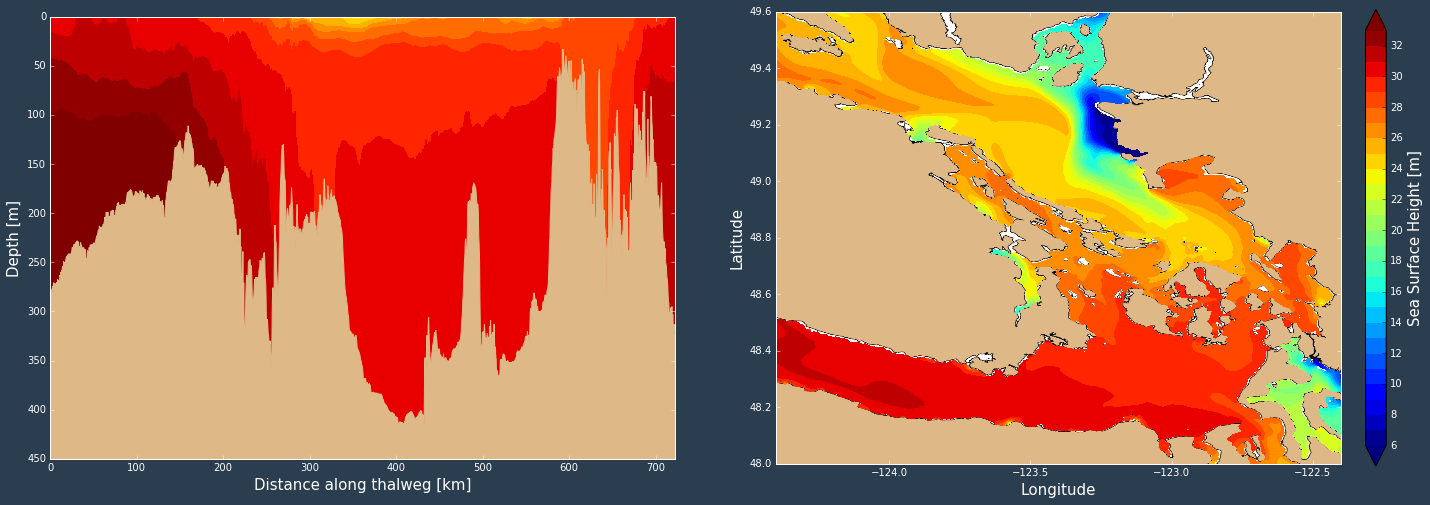

In [13]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')

grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, lons, lats = tidetools.get_bathy_data(grid_B)

grid_T = nc.Dataset('/results/SalishSea/nowcast/01apr16/SalishSea_1d_20160401_20160401_grid_T.nc')

var = grid_T.variables['vosaline'][0,:,:,:]

thalweg_and_surface_plot = tracer_thalweg_and_surface(var,'vosaline', bathy, lons, lats, mesh_mask, coastline)
plt.show(thalweg_and_surface_plot)